In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('white')
%matplotlib inline

# Simulation Data

In systematically measuring genotype-phenotype data, how will the data be collected, stored and analyzed? Is a small laptop enough to model the fold change calculations locally? I explore this in the following notebook.

In [2]:
# Set n_genotypes > 1000 to obtain estimates of variance in error as a function of num_measurements
# Set n_genotypes < 15 to obtain diagnostic plots (traceplot) and comparison of modelled to actual.
# You've been forewarned - for the diagnostics and modelled, plotting with > 100 takes a while...
n_genotypes = 15

means = np.random.randint(low=10, high=100, size=n_genotypes)
means = means * (means > 0)  # negative activities are not captured
sds = np.random.random(size=n_genotypes) * 30
num_measurements = np.random.randint(low=2, high=5, size=n_genotypes)

# Create simulated data.
data = []
indices = []

for i in range(n_genotypes):
    n = num_measurements[i]
    mean = means[i]
    sd = sds[i]
    
    measurements = np.random.normal(loc=mean, scale=sd, size=n)
    # print(measurements)
    measurements = measurements * (measurements > 0)
    # print(measurements)
    
    data.extend(measurements.tolist())
    indices.extend([i] * n)

# Add baseline measurements (bl_measures)
n_bl_measures = 2
bl_measures = np.random.normal(loc=1.0, scale=0.1, size=n_bl_measures)
bl_measures = bl_measures * (bl_measures > 0)
data.extend(bl_measures)
indices.extend([n_genotypes] * n_bl_measures)
num_measurements = np.append(num_measurements, n_bl_measures)
means = np.append(means, bl_measures.mean())
sds = np.append(sds, bl_measures.std())

# Add pos_ctrl measurements (pc_measures)
n_pc_measures = 10
pc_measures = np.random.normal(loc=20.0, scale=2, size=n_pc_measures)
pc_measures = pc_measures * (pc_measures > 0)
data.extend(pc_measures)
indices.extend([n_genotypes + 1] * n_pc_measures)
num_measurements = np.append(num_measurements, n_pc_measures)
means = np.append(means, pc_measures.mean())
sds = np.append(sds, pc_measures.std())

# convert indices to a numpy array
indices = np.array(indices)

In [3]:
indices

array([ 0,  0,  1,  1,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  4,  5,  5,
        5,  5,  6,  6,  7,  7,  8,  8,  9,  9,  9,  9, 10, 10, 11, 11, 11,
       12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16])

In [4]:
means

array([ 45.        ,  80.        ,  50.        ,  46.        ,
        57.        ,  78.        ,  28.        ,  23.        ,
        78.        ,  34.        ,  52.        ,  15.        ,
        35.        ,  90.        ,  61.        ,   1.05294924,  19.11834014])

In [5]:
sds

array([ 25.11011314,  13.45720222,   8.00951741,   0.96707642,
        26.62858749,  27.69933349,   6.76182269,  20.8481832 ,
         8.03480798,   5.77201978,   5.94702733,   3.32562107,
        18.09500348,  16.44885538,   4.31119771,   0.16512218,   1.86911019])

In [6]:
num_measurements

array([ 2,  4,  2,  3,  4,  4,  2,  2,  2,  4,  2,  3,  2,  4,  4,  2, 10])

In [7]:
len(data), len(indices)

(56, 56)

In [8]:
np.array(data)

array([   1.56135225,   36.44680449,   82.29288628,   88.44724584,
         69.33060563,   93.96762154,   53.42179458,   29.91435386,
         45.022664  ,   46.60188974,   45.49677557,   21.53452288,
         59.09645261,   71.27286958,   13.75808637,   54.9200346 ,
        104.67808277,   57.95587115,   73.10602764,   43.50935388,
         30.75472617,   12.98587588,   24.14324862,   74.89940034,
         71.29624516,   23.75472893,   33.848731  ,   29.64146774,
         36.22351404,   50.50731302,   47.2048328 ,   16.01012955,
         13.38779992,   15.67357013,   31.34806432,   29.1040849 ,
         99.10372041,  117.47987488,  108.9952878 ,   69.46127844,
         68.45353286,   63.54126505,   52.0682295 ,   54.32009463,
          1.21807142,    0.88782707,   16.99428512,   19.12215833,
         17.16761062,   21.12606224,   17.32969914,   20.63676658,
         21.94940058,   19.20587354,   20.93399447,   16.7175508 ])

In [9]:
zp_det = 1 - (3 * sds[-2] + 3 * sds[-1]) / np.abs(means[-2] - means[-1])
zp_det

0.66218848413506914

In [10]:
with pm.Model() as model:
    # Hyperpriors
    # fold_mu = pm.Flat('fold_mu')
    # fold_sd = pm.HalfCauchy('fold_sd', 100)
    # fold_alpha = pm.Flat('fold_alpha')
    # fold_beta = pm.Flat('fold_beta')
    # fold_tau = pm.Exponential('fold_tau', lam=10)
    # fold_lam = pm.Beta('fold_lam', alpha=10, beta=1)

    # "Intercept", which is basically the measurement values.
    # fold = pm.Gamma('fold', alpha=1, beta=2, shape=n_genotypes+1)
    # fold = pm.HalfNormal('fold', tau=fold_tau, shape=n_genotypes+2)
    # fold = pm.Exponential('fold', lam=fold_lam, shape=n_genotypes+2)
    upper = pm.Exponential('upper', lam=0.5)
    fold = pm.Uniform('fold', lower=1E-9, upper=upper, shape=n_genotypes+2)
    
    # Assume that data have heteroskedastic (i.e. variable) error but are drawn from the same distribution
    sigma = pm.Gamma('sigma', alpha=1, beta=1, shape=n_genotypes+2)
    
    # Model prediction
    mu = fold[indices]
    sig = sigma[indices]
    
    # Data likelihood
    like = pm.Normal('like', mu=mu, sd=sig, observed=data)
    
    # Compute Z-factors relative to positive ctrl.
    z_factor = pm.Deterministic('z_factor', 1 - (3 * sigma[:-1] + 3 * sigma[-1]) / np.abs(fold[:-1] - fold[-1]))
    
    # Compute Z-prime factor between negative and positive control.
    zp_factor = pm.Deterministic('zp_factor', 1 - (3 * sigma[-2] + 3 * sigma[-1]) / np.abs(fold[-2] - fold[-1]))
    
    # Compute fold changes
    fold_changes = pm.Deterministic('fold_changes', fold[:-2] / fold[-1])

Applied log-transform to upper and added transformed upper_log_ to model.
Applied interval-transform to fold and added transformed fold_interval_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [11]:
%%time
with model:
    if n_genotypes <= 10:
        n_steps = 150000
    elif n_genotypes > 10:
        n_steps = 200000
    params = pm.variational.advi(n=n_steps)
    trace = pm.variational.sample_vp(params, draws=2000)

Iteration 0 [0%]: ELBO = -91306.69
Iteration 20000 [10%]: Average ELBO = -35738.13
Iteration 40000 [20%]: Average ELBO = -527.45
Iteration 60000 [30%]: Average ELBO = -384.4
Iteration 80000 [40%]: Average ELBO = -355.66
Iteration 100000 [50%]: Average ELBO = -344.14
Iteration 120000 [60%]: Average ELBO = -342.19
Iteration 140000 [70%]: Average ELBO = -341.35
Iteration 160000 [80%]: Average ELBO = -341.15
Iteration 180000 [90%]: Average ELBO = -341.25
Finished [100%]: Average ELBO = -341.02
CPU times: user 28.2 s, sys: 637 ms, total: 28.8 s
Wall time: 39.2 s


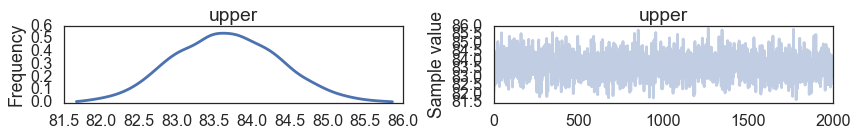

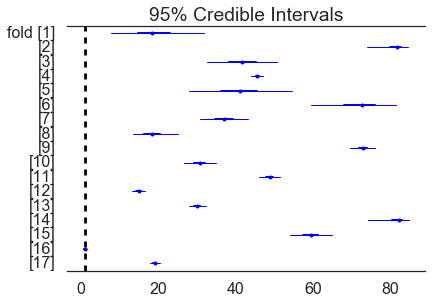

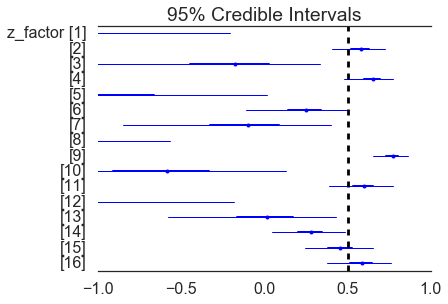

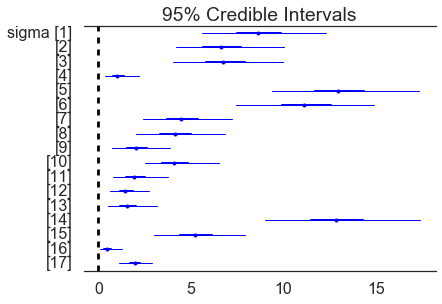

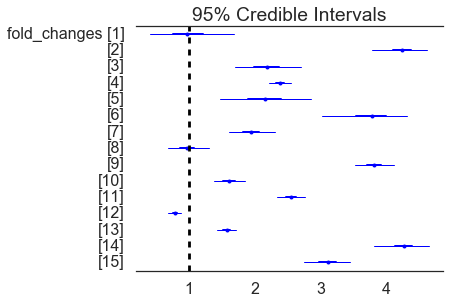

In [13]:
if n_genotypes <= 15:
    fig = plt.figure()
    pm.traceplot(trace, varnames=['upper'])
    
    fig = plt.figure()
    pm.forestplot(trace, vline=1, varnames=['fold'])
    
    fig = plt.figure()
    pm.forestplot(trace, varnames=['z_factor'], xrange=(-1, 1), vline=0.5)
    
    fig = plt.figure()
    pm.forestplot(trace, varnames=['sigma'])
    
    plt.figure()
    pm.forestplot(trace, varnames=['fold_changes'], vline=1)

In [14]:
# plt.figure()
# pm.forestplot(trace, varnames=['fold_lam'])
# plt.figure()
# pm.traceplot(trace, varnames=['fold_lam'])

In [15]:
if n_genotypes <= 15:
    pm.summary(trace)


upper:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  83.662           0.700            0.016            [82.377, 85.096]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  82.339         83.155         83.658         84.144         85.066


fold:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  19.308           6.376            0.163            [7.772, 31.771]
  80.593           3.324            0.072            [73.956, 84.622]
  41.701           4.853            0.111            [32.561, 50.778]
  45.642           0.737            0.016            [44.061, 46.982]
  41.114           6.849            0.151            [27.864, 54.542]
  71.454           6.189            0.138         

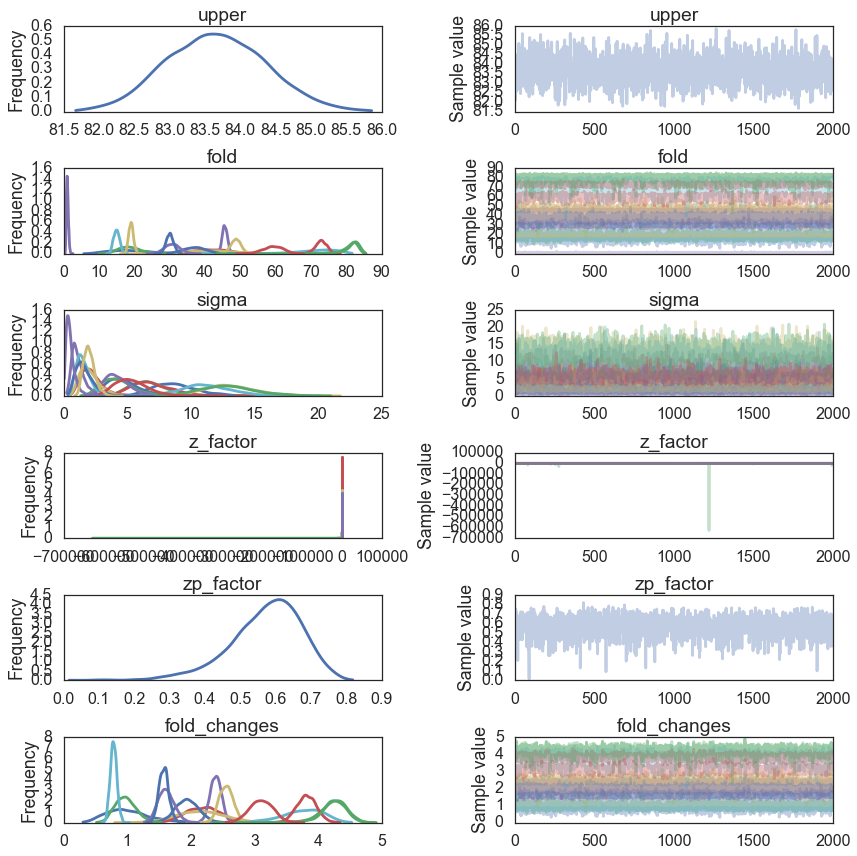

In [16]:
if n_genotypes <= 15:
    pm.traceplot(trace)

# Error in Estimated Mean

What is the error in estimated mean as a function of the number of measurements?

In [17]:
num_measurements

array([ 2,  4,  2,  3,  4,  4,  2,  2,  2,  4,  2,  3,  2,  4,  4,  2, 10])

In [18]:
trace['fold'].mean(axis=0) - means

array([ -2.56918236e+01,   5.92901924e-01,  -8.29864055e+00,
        -3.57847216e-01,  -1.58860166e+01,  -6.54575961e+00,
         9.07282165e+00,  -4.41746589e+00,  -5.13210000e+00,
        -3.22588623e+00,  -3.21133170e+00,  -1.35942106e-02,
        -4.93558101e+00,  -8.96846220e+00,  -1.69574032e+00,
         1.77069265e-02,  -2.32528762e-02])

In [19]:
import pandas as pd
errors_df = pd.DataFrame([num_measurements, (trace['fold'].mean(axis=0) - means)]).T
errors_df.columns = ['num_measurements', 'error_means']
errors_df.head()

,num_measurements,error_means
0,2.0,-25.691824
1,4.0,0.592902
2,2.0,-8.298641
3,3.0,-0.357847
4,4.0,-15.886017


In [20]:
if n_genotypes >= 500:
    sns.boxplot(data=errors_df, x='num_measurements', y='error_means')
    errors_df.groupby('num_measurements').var().plot(legend=False)
    plt.ylabel('var(error)')

In [21]:
(trace['fold'].mean(axis=0) - means).mean()

-4.6305924448103122

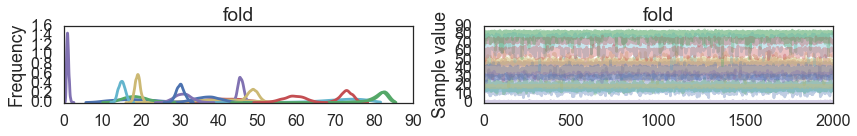

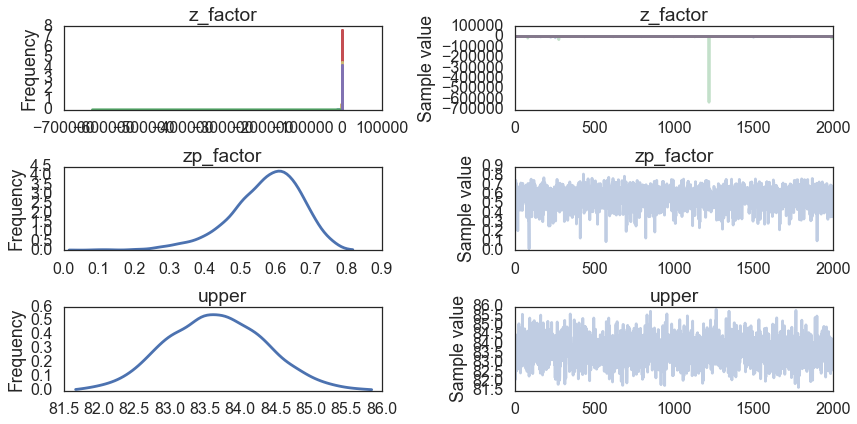

In [25]:
if n_genotypes <= 15:
    plt.figure()
    pm.traceplot(trace, varnames=['fold'])
    plt.figure()
    pm.traceplot(trace, varnames=['z_factor', 'zp_factor', 'upper'])

# Compare modelled to actual

In [26]:
trace['fold'].mean(axis=0)

array([ 19.30817637,  80.59290192,  41.70135945,  45.64215278,
        41.11398338,  71.45424039,  37.07282165,  18.58253411,
        72.8679    ,  30.77411377,  48.7886683 ,  14.98640579,
        30.06441899,  81.0315378 ,  59.30425968,   1.07065617,  19.09508727])

In [27]:
trace['fold'].mean(axis=0).shape

(17,)

In [28]:
np.arange(1, n_genotypes+3).shape

(17,)

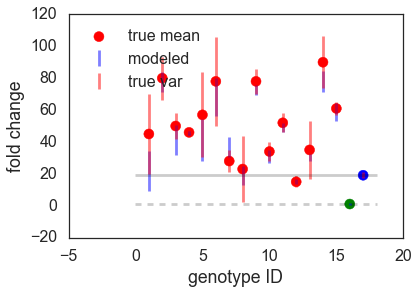

In [29]:
if n_genotypes <= 15:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lower = trace['fold'].mean(axis=0) - np.percentile(trace['fold'], 2.5, axis=0)
    upper = np.percentile(trace['fold'], 97.5, axis=0) - trace['fold'].mean(axis=0)
    yerr_pos = [lower, upper]
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=trace['fold'].mean(axis=0), 
                # y-error bars
                yerr=yerr_pos,
                # styling
                color='blue', ls='none', alpha=0.5, label='modeled',)
    ax.scatter(x=np.arange(1, n_genotypes+3), y=means, 
               # styling
               color=['red'] * (n_genotypes) + ['green'] + ['blue'], marker='o', s=100, label='true mean',)
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=means,
               yerr=sds,
               color='red', ls='none', alpha=0.5, label='true var')
    ax.legend(loc='upper left', frameon=False)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-2], linestyles='--', alpha=0.2)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-1], alpha=0.2)
    ax.set_xlabel('genotype ID')
    ax.set_ylabel('fold change')
    # ax.set_xlim(, n_genotypes+2)

just for checking the above plot...


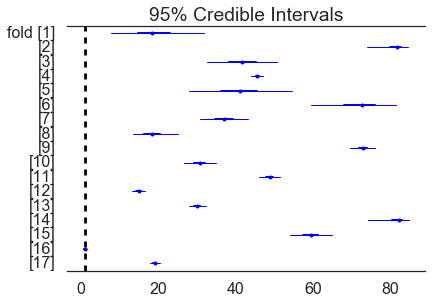

In [30]:
if n_genotypes <= 15:
    fig = plt.figure()
    pm.forestplot(trace, vline=1, varnames=['fold'])
print('just for checking the above plot...')

How does Z-factor vary as a function of variance for a fixed set of replicate measurements?

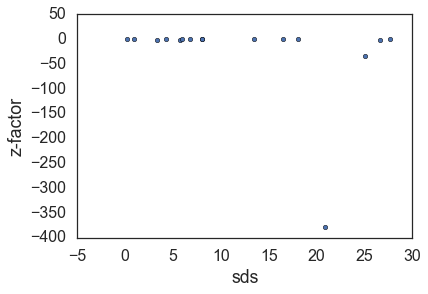

In [32]:
df = pd.DataFrame()
df['z-factor'] = trace['z_factor'].mean(axis=0)
df['num_measurements'] = num_measurements[:-1]
df['sds'] = sds[:-1]

df.plot(kind='scatter', x='sds', y='z-factor')

In [33]:
num_measurements.shape

(17,)

In [34]:
trace['z_factor'].shape

(2000, 16)